In [0]:
! pip install -U segmentation-models==0.2.1

     |████████████████████████████████| 51kB 2.0MB/s 
     |████████████████████████████████| 81kB 4.5MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from imutils import paths
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
from tqdm import tqdm
import numpy as np
import cv2
import gc
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
# Load the TensorBoard notebook extension
from keras.callbacks import TensorBoard
%load_ext tensorboard
import tensorflow as tf
import datetime, os
from keras.callbacks import EarlyStopping

from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [0]:
def IoU(y_val, y_pred):
    '''Computing average area over intersection'''
    class_iou = []
    n_classes = 8
    
    y_predi = np.argmax(y_pred, axis=3)
    y_truei = np.argmax(y_val, axis=3)
    
    for c in range(n_classes):
        TP = np.sum((y_truei == c) & (y_predi == c))
        FP = np.sum((y_truei != c) & (y_predi == c))
        FN = np.sum((y_truei == c) & (y_predi != c)) 
        IoU = TP / float(TP + FP + FN)
        if(float(TP + FP + FN) == 0):
          IoU=TP/0.001
        class_iou.append(IoU)
    MIoU=sum(class_iou)/n_classes
    return MIoU
def miou( y_true, y_pred ) :
    score = tf.py_function( lambda y_true, y_pred : IoU( y_true, y_pred).astype('float32'),
                        [y_true, y_pred],
                        'float32')
    return score

#Define model

In [0]:
#RESNET AS BACKBONE
model = Unet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True,classes=8)
model.compile('Adam', loss="categorical_crossentropy", metrics=['accuracy',miou])
model.summary()

85524480/85521592 [==============================] - 1s 0us/step
Model: "u-resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_1[0][0]           
________________________

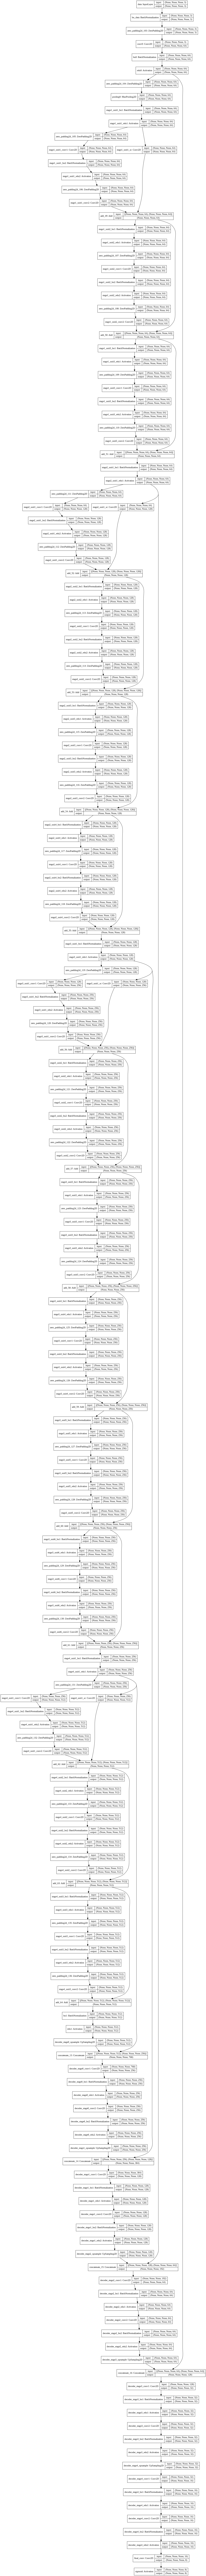

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='Keras.png', show_shapes=True, show_layer_names=True)

In [0]:
%cd /content/drive/My Drive/IDD

/content/drive/My Drive/IDD


#Converting val data to vector representation
1. Read original image as matrix of pixel
2. Read label (mask) and convert to one hot encoding

In [0]:
from imutils import paths
from tqdm import tqdm
labels_path = paths.list_images("/content/drive/My Drive/IDD/JSON_IMG/Val_Label")
labels_path = sorted(labels_path)


import cv2
from keras.utils.np_utils import to_categorical
import numpy as np
colors = np.array([
    [0,1,0,0,0,0,0,0],      
    [0,0,1,0,0,0,0,0],     
    [0,0,0,1,0,0,0,0],      
    [0,0,0,0,1,0,0,0],       
    [0,0,0,0,0,1,0,0],     
    [0,0,0,0,0,0,1,0],       
    [0,0,0,0,0,0,0,1],     
    [1,0,0,0,0,0,0,0]           
], dtype=np.int)

image_y_cv = []
for name in tqdm(labels_path):
  image = cv2.imread(name)
  image = cv2.resize(image, (256, 256))
  r,g,b =cv2.split(image)
  color_image = np.zeros(
        (r.shape[0], r.shape[1], 8), dtype=np.int)
  for i in range(8):
    color_image[r == i] = colors[i]
  image_y_cv.append(color_image)

from imutils import paths
x_path = paths.list_images("/content/drive/My Drive/IDD/leftImg8bit/val")
x_path = sorted(x_path)

import cv2
image_cv = []
for name in tqdm(x_path):
  image = cv2.imread(name)
  image_cv.append(cv2.resize(image, (256, 256))/255)

import numpy as np
image_cv = np.array(image_cv)
image_y_cv = np.array(image_y_cv)
image_y_cv.shape,image_cv.shape

  



100%|██████████| 1055/1055 [08:32<00:00,  2.06it/s]


((1055, 256, 256, 8), (1055, 256, 256, 3))

In [0]:
from imutils import paths
x_path = paths.list_images("/content/drive/My Drive/IDD/leftImg8bit/train")
x_path = sorted(x_path)
x_path[:5]
from imutils import paths
labels_path = paths.list_images("/content/drive/My Drive/IDD/JSON_IMG/Train_Label")
labels_path = sorted(labels_path)
#labels_path = labels_path[:2001]
labels_path[:5],x_path[:5],len(labels_path),len(x_path)

(['/content/drive/My Drive/IDD/JSON_IMG/Train_Label/201_frame0029_gtFine_polygons.png',
  '/content/drive/My Drive/IDD/JSON_IMG/Train_Label/201_frame0299_gtFine_polygons.png',
  '/content/drive/My Drive/IDD/JSON_IMG/Train_Label/201_frame0779_gtFine_polygons.png',
  '/content/drive/My Drive/IDD/JSON_IMG/Train_Label/201_frame1019_gtFine_polygons.png',
  '/content/drive/My Drive/IDD/JSON_IMG/Train_Label/201_frame1469_gtFine_polygons.png'],
 ['/content/drive/My Drive/IDD/leftImg8bit/train/201/frame0029_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/train/201/frame0299_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/train/201/frame0779_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/train/201/frame1019_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/train/201/frame1469_leftImg8bit.jpg'],
 7034,
 7034)

In [0]:
import cv2
import gc
import numpy as np
from tqdm import tqdm
colors = np.array([
    [0,1,0,0,0,0,0,0],      
    [0,0,1,0,0,0,0,0],     
    [0,0,0,1,0,0,0,0],      
    [0,0,0,0,1,0,0,0],        
    [0,0,0,0,0,1,0,0],    
    [0,0,0,0,0,0,1,0],      
    [0,0,0,0,0,0,0,1],     
    [1,0,0,0,0,0,0,0]           
], dtype=np.int)
#global block
block = 0
def train_label():
    ''' Since train data doesn't fit on RAM.Than we would create a pipeline so that we pass a part of data for training and fit it on RAM'''
  global block
  image_y = []
  if block + 200 <= 7034:
    for name in tqdm(labels_path[block:block + 200]):
      image = cv2.imread(name)
      image = cv2.resize(image, (256, 256))
      r,g,b =cv2.split(image)
      color_image = np.zeros(
        (r.shape[0], r.shape[1], 8), dtype=np.int)
      for i in range(8):
        color_image[r == i] = colors[i]

      image_y.append(color_image)
    block = block + 200
  elif block < 7034:
      for name in labels_path[block:]:
        image = cv2.imread(name)
        image = cv2.resize(image, (256, 256))
        r,g,b =cv2.split(image)
        color_image = np.zeros((r.shape[0], r.shape[1], 8), dtype=np.int)
        for i in range(8):
          color_image[r == i] = colors[i]
        image_y.append(color_image)
      block = 0
  else:
    block = 0
    for name in tqdm(labels_path[block:block + 200]):
      image = cv2.imread(name)
      image = cv2.resize(image, (256, 256))
      r,g,b =cv2.split(image)
      color_image = np.zeros((r.shape[0], r.shape[1], 8), dtype=np.int)
      for i in range(8):
        color_image[r == i] = colors[i]
      image_y.append(color_image)
    block = block + 200
  image_y = np.array(image_y)
  collected = gc.collect()  
  print("Garbage collector: collected", 
          "%d objects." % collected)
  return image_y


  


In [0]:
import cv2
block_1 = 0
def train():
    ''' Since train data doesn't fit on RAM.Than we would create a pipeline so that we pass a part of data for training and fit it on RAM'''
  collected = gc.collect()
  print("Garbage collector: collected","%d objects." % collected) 
  global block_1
  image_tr = []
  if block_1 + 200 <= 7034:
    for name in tqdm(x_path[block_1:block_1 + 200]):
      image = cv2.imread(name)
      img = cv2.resize(image, (256, 256))
      img = np.float32(img)  / 255 
      image_tr.append(img)
    block_1 = block_1 + 200
  elif block_1 < 7034:
    for name in tqdm(x_path[block_1:]):
      image = cv2.imread(name)
      img = cv2.resize(image, (256, 256))
      img = np.float32(img)  / 255 
      image_tr.append(img)
    block_1 = 0
  else:
    block_1 = 0
    for name in tqdm(x_path[block_1:block_1 + 200]):
      image = cv2.imread(name)
      img = cv2.resize(image, (256, 256))
      img = np.float32(img)  / 255
      image_tr.append(img)
    block_1 = block_1 + 200
  image_tr = np.array(image_tr)
  return image_tr 





In [0]:
flag = 36
history_1 = []
while(flag):
  x  = train()  
  y = train_label()
  history = model.fit(x,y,batch_size=5,epochs = 3,validation_data=(image_cv,image_y_cv))
  history_1.append(history)
  flag = flag - 1



  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 952 objects.


100%|██████████| 200/200 [01:07<00:00,  2.96it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
 65/200 [========>.....................] - ETA: 47s - loss: 1.7424 - accuracy: 0.5777 - miou: 0.2072

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


200/200 [==============================] - 71s 353ms/step - loss: 1.3633 - accuracy: 0.7174 - miou: 0.2551 - val_loss: 1.9469 - val_accuracy: 0.3081 - val_miou: 0.0610
Epoch 2/3
200/200 [==============================] - 49s 245ms/step - loss: 0.6963 - accuracy: 0.8123 - miou: 0.2952 - val_loss: 1.8528 - val_accuracy: 0.4337 - val_miou: 0.1082
Epoch 3/3
200/200 [==============================] - 50s 252ms/step - loss: 0.5173 - accuracy: 0.8198 - miou: 0.3009 - val_loss: 1.8759 - val_accuracy: 0.3215 - val_miou: 0.0640


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:05<00:00,  3.03it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 47s 233ms/step - loss: 0.4847 - accuracy: 0.8185 - miou: 0.3139 - val_loss: 2.3318 - val_accuracy: 0.3466 - val_miou: 0.0674
Epoch 2/3
200/200 [==============================] - 46s 231ms/step - loss: 0.4199 - accuracy: 0.8523 - miou: 0.3927 - val_loss: 3.0259 - val_accuracy: 0.2836 - val_miou: 0.0624
Epoch 3/3
200/200 [==============================] - 47s 234ms/step - loss: 0.3783 - accuracy: 0.8696 - miou: 0.4204 - val_loss: 3.1416 - val_accuracy: 0.3275 - val_miou: 0.0775
Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:08<00:00,  2.93it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 47s 233ms/step - loss: 0.6166 - accuracy: 0.7764 - miou: 0.3892 - val_loss: 2.9273 - val_accuracy: 0.3292 - val_miou: 0.0872
Epoch 2/3
200/200 [==============================] - 46s 232ms/step - loss: 0.5291 - accuracy: 0.8068 - miou: 0.4187 - val_loss: 4.5362 - val_accuracy: 0.3200 - val_miou: 0.0503
Epoch 3/3
200/200 [==============================] - 47s 234ms/step - loss: 0.4856 - accuracy: 0.8249 - miou: 0.4435 - val_loss: 3.3959 - val_accuracy: 0.2821 - val_miou: 0.0842
Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:16<00:00,  2.60it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 46s 231ms/step - loss: 0.5420 - accuracy: 0.7986 - miou: 0.3968 - val_loss: 3.4952 - val_accuracy: 0.3265 - val_miou: 0.0880
Epoch 2/3
200/200 [==============================] - 46s 231ms/step - loss: 0.4784 - accuracy: 0.8238 - miou: 0.4198 - val_loss: 3.2811 - val_accuracy: 0.3259 - val_miou: 0.0820
Epoch 3/3
200/200 [==============================] - 48s 238ms/step - loss: 0.4623 - accuracy: 0.8284 - miou: 0.4226 - val_loss: 2.7775 - val_accuracy: 0.3717 - val_miou: 0.0878
Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:07<00:00,  2.98it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 46s 232ms/step - loss: 0.4761 - accuracy: 0.8302 - miou: 0.3980 - val_loss: 1.8331 - val_accuracy: 0.5243 - val_miou: 0.1509
Epoch 2/3
200/200 [==============================] - 46s 232ms/step - loss: 0.4091 - accuracy: 0.8509 - miou: 0.4391 - val_loss: 2.3387 - val_accuracy: 0.4112 - val_miou: 0.1169
Epoch 3/3
200/200 [==============================] - 48s 239ms/step - loss: 0.3791 - accuracy: 0.8625 - miou: 0.4572 - val_loss: 2.2630 - val_accuracy: 0.4917 - val_miou: 0.1451


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:11<00:00,  2.80it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 46s 232ms/step - loss: 0.4049 - accuracy: 0.8504 - miou: 0.4359 - val_loss: 1.4044 - val_accuracy: 0.6621 - val_miou: 0.2379
Epoch 2/3
200/200 [==============================] - 47s 233ms/step - loss: 0.3612 - accuracy: 0.8669 - miou: 0.4683 - val_loss: 1.3348 - val_accuracy: 0.7005 - val_miou: 0.2574
Epoch 3/3
200/200 [==============================] - 48s 239ms/step - loss: 0.3356 - accuracy: 0.8798 - miou: 0.4893 - val_loss: 1.1976 - val_accuracy: 0.7140 - val_miou: 0.2756


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:03<00:00,  3.16it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 46s 232ms/step - loss: 0.3600 - accuracy: 0.8690 - miou: 0.4302 - val_loss: 1.1334 - val_accuracy: 0.7195 - val_miou: 0.2775
Epoch 2/3
200/200 [==============================] - 46s 230ms/step - loss: 0.3105 - accuracy: 0.8889 - miou: 0.4689 - val_loss: 1.1425 - val_accuracy: 0.7441 - val_miou: 0.2802
Epoch 3/3
200/200 [==============================] - 46s 231ms/step - loss: 0.2994 - accuracy: 0.8912 - miou: 0.4747 - val_loss: 1.2174 - val_accuracy: 0.7227 - val_miou: 0.2708


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:04<00:00,  3.12it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 46s 228ms/step - loss: 0.2881 - accuracy: 0.8994 - miou: 0.4619 - val_loss: 1.2450 - val_accuracy: 0.7111 - val_miou: 0.2833
Epoch 2/3
200/200 [==============================] - 45s 227ms/step - loss: 0.2331 - accuracy: 0.9185 - miou: 0.5081 - val_loss: 0.8460 - val_accuracy: 0.7605 - val_miou: 0.3278
Epoch 3/3
200/200 [==============================] - 46s 228ms/step - loss: 0.2120 - accuracy: 0.9269 - miou: 0.5236 - val_loss: 0.7877 - val_accuracy: 0.7644 - val_miou: 0.3432


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:09<00:00,  2.87it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 46s 231ms/step - loss: 0.6073 - accuracy: 0.7885 - miou: 0.4095 - val_loss: 0.5569 - val_accuracy: 0.8161 - val_miou: 0.3958
Epoch 2/3
200/200 [==============================] - 46s 230ms/step - loss: 0.5011 - accuracy: 0.8195 - miou: 0.4418 - val_loss: 0.5039 - val_accuracy: 0.8243 - val_miou: 0.4020
Epoch 3/3
200/200 [==============================] - 46s 231ms/step - loss: 0.4564 - accuracy: 0.8358 - miou: 0.4576 - val_loss: 0.5573 - val_accuracy: 0.7907 - val_miou: 0.3857


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:11<00:00,  2.78it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 46s 230ms/step - loss: 0.4456 - accuracy: 0.8382 - miou: 0.4328 - val_loss: 0.4761 - val_accuracy: 0.8225 - val_miou: 0.4101
Epoch 2/3
200/200 [==============================] - 46s 228ms/step - loss: 0.4045 - accuracy: 0.8536 - miou: 0.4571 - val_loss: 0.4519 - val_accuracy: 0.8355 - val_miou: 0.4240
Epoch 3/3
200/200 [==============================] - 46s 228ms/step - loss: 0.3596 - accuracy: 0.8659 - miou: 0.4732 - val_loss: 0.4370 - val_accuracy: 0.8397 - val_miou: 0.4165


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:09<00:00,  2.89it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 46s 230ms/step - loss: 0.4031 - accuracy: 0.8528 - miou: 0.4643 - val_loss: 0.4657 - val_accuracy: 0.8298 - val_miou: 0.4205
Epoch 2/3
200/200 [==============================] - 46s 228ms/step - loss: 0.3591 - accuracy: 0.8694 - miou: 0.4934 - val_loss: 0.4265 - val_accuracy: 0.8464 - val_miou: 0.4368
Epoch 3/3
200/200 [==============================] - 46s 228ms/step - loss: 0.3368 - accuracy: 0.8781 - miou: 0.5092 - val_loss: 0.4239 - val_accuracy: 0.8420 - val_miou: 0.4416


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:18<00:00,  2.54it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 46s 230ms/step - loss: 0.3654 - accuracy: 0.8739 - miou: 0.4445 - val_loss: 0.4493 - val_accuracy: 0.8362 - val_miou: 0.4116
Epoch 2/3
200/200 [==============================] - 46s 229ms/step - loss: 0.3141 - accuracy: 0.8862 - miou: 0.4656 - val_loss: 0.4419 - val_accuracy: 0.8410 - val_miou: 0.4281
Epoch 3/3
200/200 [==============================] - 46s 230ms/step - loss: 0.2910 - accuracy: 0.8955 - miou: 0.4781 - val_loss: 0.4183 - val_accuracy: 0.8469 - val_miou: 0.4534


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:07<00:00,  2.94it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 47s 234ms/step - loss: 0.3012 - accuracy: 0.9012 - miou: 0.5113 - val_loss: 0.4326 - val_accuracy: 0.8434 - val_miou: 0.4485
Epoch 2/3
200/200 [==============================] - 47s 234ms/step - loss: 0.2626 - accuracy: 0.9121 - miou: 0.5371 - val_loss: 0.4288 - val_accuracy: 0.8464 - val_miou: 0.4428
Epoch 3/3
200/200 [==============================] - 48s 238ms/step - loss: 0.2450 - accuracy: 0.9187 - miou: 0.5510 - val_loss: 0.4304 - val_accuracy: 0.8470 - val_miou: 0.4525


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:10<00:00,  2.82it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 47s 235ms/step - loss: 0.3471 - accuracy: 0.8805 - miou: 0.5025 - val_loss: 0.4467 - val_accuracy: 0.8296 - val_miou: 0.4362
Epoch 2/3
200/200 [==============================] - 46s 232ms/step - loss: 0.3039 - accuracy: 0.8952 - miou: 0.5220 - val_loss: 0.4261 - val_accuracy: 0.8445 - val_miou: 0.4630
Epoch 3/3
200/200 [==============================] - 46s 231ms/step - loss: 0.2838 - accuracy: 0.8997 - miou: 0.5475 - val_loss: 0.4441 - val_accuracy: 0.8430 - val_miou: 0.4461


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:10<00:00,  2.84it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 47s 236ms/step - loss: 0.3198 - accuracy: 0.8827 - miou: 0.5019 - val_loss: 0.4890 - val_accuracy: 0.8299 - val_miou: 0.4241
Epoch 2/3
200/200 [==============================] - 48s 240ms/step - loss: 0.2722 - accuracy: 0.9014 - miou: 0.5407 - val_loss: 0.4878 - val_accuracy: 0.8264 - val_miou: 0.4551
Epoch 3/3
200/200 [==============================] - 46s 231ms/step - loss: 0.2505 - accuracy: 0.9100 - miou: 0.5533 - val_loss: 0.4791 - val_accuracy: 0.8299 - val_miou: 0.4530


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:06<00:00,  2.99it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 46s 232ms/step - loss: 0.2208 - accuracy: 0.9220 - miou: 0.5144 - val_loss: 0.4243 - val_accuracy: 0.8436 - val_miou: 0.4617
Epoch 2/3
200/200 [==============================] - 48s 240ms/step - loss: 0.1942 - accuracy: 0.9317 - miou: 0.5412 - val_loss: 0.4282 - val_accuracy: 0.8453 - val_miou: 0.4680
Epoch 3/3
200/200 [==============================] - 48s 242ms/step - loss: 0.1834 - accuracy: 0.9350 - miou: 0.5508 - val_loss: 0.4276 - val_accuracy: 0.8457 - val_miou: 0.4699


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:08<00:00,  2.91it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 49s 243ms/step - loss: 0.2609 - accuracy: 0.9117 - miou: 0.5366 - val_loss: 0.4308 - val_accuracy: 0.8438 - val_miou: 0.4694
Epoch 2/3
200/200 [==============================] - 47s 234ms/step - loss: 0.2365 - accuracy: 0.9192 - miou: 0.5554 - val_loss: 0.4254 - val_accuracy: 0.8470 - val_miou: 0.4747
Epoch 3/3
200/200 [==============================] - 46s 232ms/step - loss: 0.2261 - accuracy: 0.9229 - miou: 0.5743 - val_loss: 0.4354 - val_accuracy: 0.8428 - val_miou: 0.4811


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:05<00:00,  3.05it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 47s 234ms/step - loss: 0.4368 - accuracy: 0.8462 - miou: 0.4807 - val_loss: 0.4908 - val_accuracy: 0.8401 - val_miou: 0.4274
Epoch 2/3
200/200 [==============================] - 46s 232ms/step - loss: 0.3953 - accuracy: 0.8597 - miou: 0.4918 - val_loss: 0.4035 - val_accuracy: 0.8529 - val_miou: 0.4647
Epoch 3/3
200/200 [==============================] - 47s 234ms/step - loss: 0.3551 - accuracy: 0.8746 - miou: 0.5245 - val_loss: 0.3939 - val_accuracy: 0.8566 - val_miou: 0.4772


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:02<00:00,  3.22it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 47s 233ms/step - loss: 0.3711 - accuracy: 0.8603 - miou: 0.4965 - val_loss: 0.4040 - val_accuracy: 0.8507 - val_miou: 0.4762
Epoch 2/3
200/200 [==============================] - 47s 233ms/step - loss: 0.3284 - accuracy: 0.8773 - miou: 0.5303 - val_loss: 0.4028 - val_accuracy: 0.8503 - val_miou: 0.4681
Epoch 3/3
200/200 [==============================] - 47s 233ms/step - loss: 0.3078 - accuracy: 0.8867 - miou: 0.5532 - val_loss: 0.3976 - val_accuracy: 0.8547 - val_miou: 0.4690


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:03<00:00,  3.15it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 49s 245ms/step - loss: 0.3990 - accuracy: 0.8518 - miou: 0.4997 - val_loss: 0.4068 - val_accuracy: 0.8548 - val_miou: 0.4700
Epoch 2/3
200/200 [==============================] - 47s 235ms/step - loss: 0.3650 - accuracy: 0.8643 - miou: 0.5125 - val_loss: 0.3822 - val_accuracy: 0.8558 - val_miou: 0.4788
Epoch 3/3
200/200 [==============================] - 47s 233ms/step - loss: 0.3499 - accuracy: 0.8702 - miou: 0.5269 - val_loss: 0.3833 - val_accuracy: 0.8576 - val_miou: 0.4891


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:03<00:00,  3.14it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 47s 235ms/step - loss: 0.4287 - accuracy: 0.8434 - miou: 0.4853 - val_loss: 0.3965 - val_accuracy: 0.8573 - val_miou: 0.4803
Epoch 2/3
200/200 [==============================] - 47s 233ms/step - loss: 0.3874 - accuracy: 0.8578 - miou: 0.5138 - val_loss: 0.3832 - val_accuracy: 0.8611 - val_miou: 0.4904
Epoch 3/3
200/200 [==============================] - 47s 233ms/step - loss: 0.3645 - accuracy: 0.8649 - miou: 0.5304 - val_loss: 0.3812 - val_accuracy: 0.8607 - val_miou: 0.4951


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:08<00:00,  2.90it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 47s 235ms/step - loss: 0.4056 - accuracy: 0.8491 - miou: 0.4960 - val_loss: 0.4314 - val_accuracy: 0.8439 - val_miou: 0.4577
Epoch 2/3
200/200 [==============================] - 47s 234ms/step - loss: 0.3671 - accuracy: 0.8620 - miou: 0.5152 - val_loss: 0.3932 - val_accuracy: 0.8551 - val_miou: 0.4752
Epoch 3/3
200/200 [==============================] - 49s 245ms/step - loss: 0.3502 - accuracy: 0.8690 - miou: 0.5254 - val_loss: 0.3814 - val_accuracy: 0.8590 - val_miou: 0.4908


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:08<00:00,  2.94it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 47s 233ms/step - loss: 0.4308 - accuracy: 0.8495 - miou: 0.5123 - val_loss: 0.4103 - val_accuracy: 0.8529 - val_miou: 0.4685
Epoch 2/3
200/200 [==============================] - 46s 232ms/step - loss: 0.3990 - accuracy: 0.8573 - miou: 0.5224 - val_loss: 0.4096 - val_accuracy: 0.8575 - val_miou: 0.4776
Epoch 3/3
200/200 [==============================] - 46s 232ms/step - loss: 0.3678 - accuracy: 0.8685 - miou: 0.5441 - val_loss: 0.3932 - val_accuracy: 0.8601 - val_miou: 0.4860


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:09<00:00,  2.89it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 47s 234ms/step - loss: 0.3387 - accuracy: 0.8779 - miou: 0.5203 - val_loss: 0.3931 - val_accuracy: 0.8583 - val_miou: 0.4889
Epoch 2/3
200/200 [==============================] - 47s 233ms/step - loss: 0.2995 - accuracy: 0.8919 - miou: 0.5448 - val_loss: 0.3874 - val_accuracy: 0.8552 - val_miou: 0.4871
Epoch 3/3
200/200 [==============================] - 47s 234ms/step - loss: 0.2797 - accuracy: 0.8993 - miou: 0.5690 - val_loss: 0.3838 - val_accuracy: 0.8573 - val_miou: 0.4997


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:07<00:00,  2.96it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 47s 233ms/step - loss: 0.3452 - accuracy: 0.8780 - miou: 0.4947 - val_loss: 0.4135 - val_accuracy: 0.8510 - val_miou: 0.4799
Epoch 2/3
200/200 [==============================] - 48s 242ms/step - loss: 0.2971 - accuracy: 0.8941 - miou: 0.5308 - val_loss: 0.4016 - val_accuracy: 0.8553 - val_miou: 0.4791
Epoch 3/3
200/200 [==============================] - 47s 234ms/step - loss: 0.2770 - accuracy: 0.9007 - miou: 0.5454 - val_loss: 0.3963 - val_accuracy: 0.8588 - val_miou: 0.4714


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:09<00:00,  2.89it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 52s 262ms/step - loss: 0.3340 - accuracy: 0.8790 - miou: 0.5056 - val_loss: 0.3727 - val_accuracy: 0.8624 - val_miou: 0.4930
Epoch 2/3
200/200 [==============================] - 49s 247ms/step - loss: 0.2897 - accuracy: 0.8941 - miou: 0.5296 - val_loss: 0.3699 - val_accuracy: 0.8635 - val_miou: 0.4806
Epoch 3/3
200/200 [==============================] - 49s 243ms/step - loss: 0.2706 - accuracy: 0.9018 - miou: 0.5464 - val_loss: 0.3770 - val_accuracy: 0.8626 - val_miou: 0.4786


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:12<00:00,  2.75it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 49s 247ms/step - loss: 0.3437 - accuracy: 0.8766 - miou: 0.5239 - val_loss: 0.4296 - val_accuracy: 0.8536 - val_miou: 0.4705
Epoch 2/3
200/200 [==============================] - 47s 237ms/step - loss: 0.2995 - accuracy: 0.8916 - miou: 0.5511 - val_loss: 0.3790 - val_accuracy: 0.8642 - val_miou: 0.4934
Epoch 3/3
200/200 [==============================] - 48s 238ms/step - loss: 0.2729 - accuracy: 0.9015 - miou: 0.5752 - val_loss: 0.3866 - val_accuracy: 0.8609 - val_miou: 0.4756


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:11<00:00,  2.80it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 48s 242ms/step - loss: 0.4417 - accuracy: 0.8338 - miou: 0.5128 - val_loss: 0.3921 - val_accuracy: 0.8553 - val_miou: 0.4933
Epoch 2/3
200/200 [==============================] - 47s 233ms/step - loss: 0.3909 - accuracy: 0.8516 - miou: 0.5382 - val_loss: 0.3664 - val_accuracy: 0.8647 - val_miou: 0.4989
Epoch 3/3
200/200 [==============================] - 48s 238ms/step - loss: 0.3679 - accuracy: 0.8616 - miou: 0.5579 - val_loss: 0.3656 - val_accuracy: 0.8635 - val_miou: 0.4910


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:12<00:00,  2.74it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 48s 242ms/step - loss: 0.3756 - accuracy: 0.8629 - miou: 0.5234 - val_loss: 0.3717 - val_accuracy: 0.8628 - val_miou: 0.5009
Epoch 2/3
200/200 [==============================] - 49s 245ms/step - loss: 0.3474 - accuracy: 0.8718 - miou: 0.5367 - val_loss: 0.3953 - val_accuracy: 0.8596 - val_miou: 0.4788
Epoch 3/3
200/200 [==============================] - 49s 246ms/step - loss: 0.3330 - accuracy: 0.8771 - miou: 0.5504 - val_loss: 0.3829 - val_accuracy: 0.8600 - val_miou: 0.4981
Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:12<00:00,  2.78it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 48s 242ms/step - loss: 0.3612 - accuracy: 0.8687 - miou: 0.5365 - val_loss: 0.3841 - val_accuracy: 0.8623 - val_miou: 0.4947
Epoch 2/3
200/200 [==============================] - 49s 243ms/step - loss: 0.3257 - accuracy: 0.8795 - miou: 0.5640 - val_loss: 0.3749 - val_accuracy: 0.8649 - val_miou: 0.4994
Epoch 3/3
200/200 [==============================] - 48s 239ms/step - loss: 0.3070 - accuracy: 0.8872 - miou: 0.5733 - val_loss: 0.3725 - val_accuracy: 0.8636 - val_miou: 0.5010


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:06<00:00,  3.03it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 50s 249ms/step - loss: 0.4262 - accuracy: 0.8413 - miou: 0.5195 - val_loss: 0.3768 - val_accuracy: 0.8641 - val_miou: 0.5007
Epoch 2/3
200/200 [==============================] - 47s 234ms/step - loss: 0.3843 - accuracy: 0.8545 - miou: 0.5411 - val_loss: 0.3788 - val_accuracy: 0.8615 - val_miou: 0.4966
Epoch 3/3
200/200 [==============================] - 48s 239ms/step - loss: 0.3543 - accuracy: 0.8683 - miou: 0.5690 - val_loss: 0.3987 - val_accuracy: 0.8600 - val_miou: 0.4974


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:04<00:00,  3.10it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 47s 234ms/step - loss: 0.3355 - accuracy: 0.8809 - miou: 0.5130 - val_loss: 0.3868 - val_accuracy: 0.8596 - val_miou: 0.4816
Epoch 2/3
200/200 [==============================] - 47s 235ms/step - loss: 0.3041 - accuracy: 0.8907 - miou: 0.5300 - val_loss: 0.3641 - val_accuracy: 0.8668 - val_miou: 0.4975
Epoch 3/3
200/200 [==============================] - 50s 250ms/step - loss: 0.2862 - accuracy: 0.8977 - miou: 0.5438 - val_loss: 0.3640 - val_accuracy: 0.8689 - val_miou: 0.4989
Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:15<00:00,  2.64it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 47s 235ms/step - loss: 0.3379 - accuracy: 0.8807 - miou: 0.5541 - val_loss: 0.3789 - val_accuracy: 0.8587 - val_miou: 0.4894
Epoch 2/3
200/200 [==============================] - 49s 245ms/step - loss: 0.2989 - accuracy: 0.8937 - miou: 0.5795 - val_loss: 0.3754 - val_accuracy: 0.8608 - val_miou: 0.4999
Epoch 3/3
200/200 [==============================] - 49s 245ms/step - loss: 0.2849 - accuracy: 0.8975 - miou: 0.5881 - val_loss: 0.3846 - val_accuracy: 0.8617 - val_miou: 0.5020


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:19<00:00,  2.52it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 49s 247ms/step - loss: 0.3695 - accuracy: 0.8808 - miou: 0.5174 - val_loss: 0.4121 - val_accuracy: 0.8455 - val_miou: 0.4857
Epoch 2/3
200/200 [==============================] - 47s 234ms/step - loss: 0.3185 - accuracy: 0.8926 - miou: 0.5359 - val_loss: 0.4481 - val_accuracy: 0.8277 - val_miou: 0.4726
Epoch 3/3
200/200 [==============================] - 49s 243ms/step - loss: 0.3022 - accuracy: 0.8970 - miou: 0.5446 - val_loss: 0.3901 - val_accuracy: 0.8574 - val_miou: 0.4916


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:11<00:00,  2.79it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 47s 235ms/step - loss: 0.3124 - accuracy: 0.8873 - miou: 0.5315 - val_loss: 0.3734 - val_accuracy: 0.8598 - val_miou: 0.4995
Epoch 2/3
200/200 [==============================] - 48s 239ms/step - loss: 0.2877 - accuracy: 0.8969 - miou: 0.5505 - val_loss: 0.3529 - val_accuracy: 0.8695 - val_miou: 0.5073
Epoch 3/3
200/200 [==============================] - 49s 247ms/step - loss: 0.2667 - accuracy: 0.9041 - miou: 0.5644 - val_loss: 0.3550 - val_accuracy: 0.8694 - val_miou: 0.5139
Garbage collector: collected 37 objects.


100%|██████████| 34/34 [00:17<00:00,  1.95it/s]


Garbage collector: collected 0 objects.
Train on 34 samples, validate on 1055 samples
Epoch 1/3
34/34 [==============================] - 40s 1s/step - loss: 0.4276 - accuracy: 0.8436 - miou: 0.4999 - val_loss: 0.3630 - val_accuracy: 0.8684 - val_miou: 0.5041
Epoch 2/3
34/34 [==============================] - 36s 1s/step - loss: 0.3829 - accuracy: 0.8582 - miou: 0.5118 - val_loss: 0.3742 - val_accuracy: 0.8653 - val_miou: 0.4954
Epoch 3/3
34/34 [==============================] - 36s 1s/step - loss: 0.3572 - accuracy: 0.8719 - miou: 0.5336 - val_loss: 0.3716 - val_accuracy: 0.8666 - val_miou: 0.4978


In [0]:
model.save("Unet_Resnet.hdf5")
print("Saved model to disk")#https://machinelearningmastery.com/save-load-keras-deep-learning-models/
#history_1 = model.fit(x  = train(),y = train_label(),batch_size=5,epochs = 100 ,callbacks=[earlyStopping, mcp_save,tensorboard_callback],validation_data=(image_cv,image_y_cv))

Saved model to disk


In [0]:
flag = 1
#history_1 = []
while(flag):
  x  = train()  
  y = train_label()
  history = model.fit(x,y,batch_size=5,epochs = 3,validation_data=(image_cv,image_y_cv))
  history_1.append(history)
  flag = int(input ("Enter 0 if you want to stop training" ))
  if flag == 0:
    break


  2%|▏         | 3/200 [00:00<00:08, 22.45it/s]

Garbage collector: collected 41 objects.


100%|██████████| 200/200 [00:05<00:00, 37.56it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
  5/200 [..............................] - ETA: 16s - loss: 0.3322 - accuracy: 0.8839 - miou: 0.5153

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


200/200 [==============================] - 47s 233ms/step - loss: 0.2878 - accuracy: 0.8992 - miou: 0.5253 - val_loss: 0.3953 - val_accuracy: 0.8569 - val_miou: 0.4944
Epoch 2/3
200/200 [==============================] - 48s 242ms/step - loss: 0.2521 - accuracy: 0.9111 - miou: 0.5621 - val_loss: 0.3794 - val_accuracy: 0.8630 - val_miou: 0.5035
Epoch 3/3
200/200 [==============================] - 49s 247ms/step - loss: 0.2355 - accuracy: 0.9176 - miou: 0.5670 - val_loss: 0.3834 - val_accuracy: 0.8645 - val_miou: 0.5041
Enter 0 if you want to stop training1


  2%|▏         | 3/200 [00:00<00:09, 21.80it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:05<00:00, 37.01it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 48s 242ms/step - loss: 0.4302 - accuracy: 0.8491 - miou: 0.5244 - val_loss: 0.5086 - val_accuracy: 0.8393 - val_miou: 0.4656
Epoch 2/3
200/200 [==============================] - 47s 234ms/step - loss: 0.3705 - accuracy: 0.8670 - miou: 0.5472 - val_loss: 0.3833 - val_accuracy: 0.8630 - val_miou: 0.5063
Epoch 3/3
200/200 [==============================] - 48s 239ms/step - loss: 0.3423 - accuracy: 0.8772 - miou: 0.5617 - val_loss: 0.3694 - val_accuracy: 0.8665 - val_miou: 0.5096
Enter 0 if you want to stop training1


  2%|▏         | 3/200 [00:00<00:09, 20.94it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:05<00:00, 34.97it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 47s 234ms/step - loss: 0.4092 - accuracy: 0.8509 - miou: 0.5010 - val_loss: 0.3716 - val_accuracy: 0.8638 - val_miou: 0.4951
Epoch 2/3
200/200 [==============================] - 48s 239ms/step - loss: 0.3601 - accuracy: 0.8672 - miou: 0.5244 - val_loss: 0.3652 - val_accuracy: 0.8661 - val_miou: 0.4985
Epoch 3/3
200/200 [==============================] - 47s 235ms/step - loss: 0.3320 - accuracy: 0.8772 - miou: 0.5358 - val_loss: 0.3621 - val_accuracy: 0.8700 - val_miou: 0.5066
Enter 0 if you want to stop training0


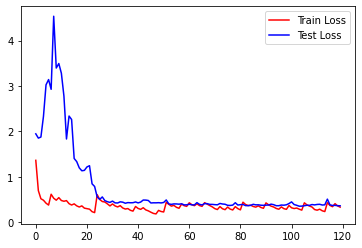

In [0]:
val_loss = []
for i in range(len(history_1)):
  val_loss.append(history_1[i].history['val_loss'])

flat_val_loss = []
for sublist in val_loss:
    for item in sublist:
        flat_val_loss.append(item)
loss = []
for i in range(len(history_1)):
  loss.append(history_1[i].history['loss'])

flat_loss = []
for sublist in loss:
    for item in sublist:
        flat_loss.append(item)

import matplotlib.pyplot as plt


plt.plot(flat_loss, 'r')
plt.plot(flat_val_loss, 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

In [0]:
val_loss = []
for i in range(len(history_1)):
  val_loss.append(history_1[i].history['val_miou'])

flat_val_loss = []
for sublist in val_loss:
    for item in sublist:
        flat_val_loss.append(item)

loss = []
for i in range(len(history_1)):
  loss.append(history_1[i].history['miou'])

flat_loss = []
for sublist in loss:
    for item in sublist:
        flat_loss.append(item)

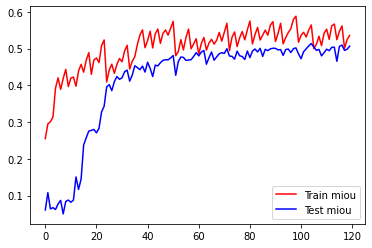

In [0]:
import matplotlib.pyplot as plt


plt.plot(flat_loss, 'r')
plt.plot(flat_val_loss, 'b')
plt.legend({'Train miou': 'r', 'Test miou':'b'})
plt.show()

In [0]:
val_loss = []
for i in range(len(history_1)):
  val_loss.append(history_1[i].history['val_accuracy'])

flat_val_loss = []
for sublist in val_loss:
    for item in sublist:
        flat_val_loss.append(item)

loss = []
for i in range(len(history_1)):
  loss.append(history_1[i].history['accuracy'])

flat_loss = []
for sublist in loss:
    for item in sublist:
        flat_loss.append(item)

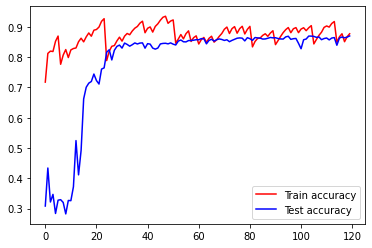

In [0]:
import matplotlib.pyplot as plt


plt.plot(flat_loss, 'r')
plt.plot(flat_val_loss, 'b')
plt.legend({'Train accuracy': 'r', 'Test accuracy':'b'})
plt.show()

In [0]:
model.save("Unet_Resnet.hdf5")
print("Saved model to disk")#https://machinelearningmastery.com/save-load-keras-deep-learning-models/
#history_1 = model.fit(x  = train(),y = train_label(),batch_size=5,epochs = 100 ,callbacks=[earlyStopping, mcp_save,tensorboard_callback],validation_data=(image_cv,image_y_cv))

Saved model to disk


#Randomly choose some test images and see the results of segmentation

In [0]:
x_path = paths.list_images("/content/drive/My Drive/IDD/leftImg8bit/test")
x_path = sorted(x_path)
x_path[:5],len(x_path)

(['/content/drive/My Drive/IDD/leftImg8bit/test/200/frame0199_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/test/200/frame0252_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/test/200/frame1090_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/test/200/frame1250_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/test/200/frame1457_leftImg8bit.jpg'],
 2009)

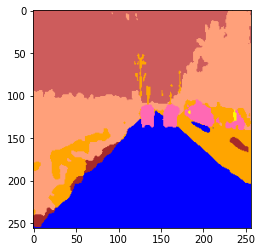

In [0]:
image_te = []
image = cv2.imread(x_path[0])
img = cv2.resize(image, (256, 256))
img = np.float32(img)  / 255 
image_te.append(img)
image_te = np.array(image_te)
result = model.predict(image_te)
result = np.argmax(result, axis=3)
colors = np.array([
    [255, 192 ,203	],      
    [255, 160, 122],     
    [255, 105, 180],      
    [205,  92,  92],        
    [255, 165,   0],    
    [255, 255,   0],      
    [165,  42,  42],     
    [0,   0, 255]           
], dtype=np.int)
image_y_te = []

color_image = np.zeros(
        (result.shape[1], result.shape[2], 3), dtype=np.int)
for i in range(8):
  color_image[result[0] == i] = colors[i]
image_y_te.append(color_image)
image_y_te = np.array(image_y_te)

from matplotlib import image
from matplotlib import pyplot

pyplot.imshow(color_image)
pyplot.show()

uint8
(1080, 1920, 3)


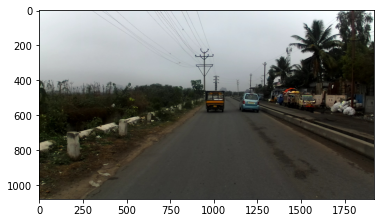

In [0]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread(x_path[0])
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

In [0]:
image_te = []
image = cv2.imread(x_path[1])
img = cv2.resize(image, (256, 256))
img = np.float32(img)  / 255 
image_te.append(img)
image_te = np.array(image_te)
result = model.predict(image_te)
result = np.argmax(result, axis=3)
colors = np.array([
    [255, 192 ,203	],      
    [255, 160, 122],     
    [255, 105, 180],      
    [205,  92,  92],        
    [255, 165,   0],    
    [255, 255,   0],      
    [165,  42,  42],     
    [0,   0, 255]           
], dtype=np.int)
image_y_te = []

color_image = np.zeros(
        (result.shape[1], result.shape[2], 3), dtype=np.int)
for i in range(8):
  color_image[result[0] == i] = colors[i]
image_y_te.append(color_image)
image_y_te = np.array(image_y_te)

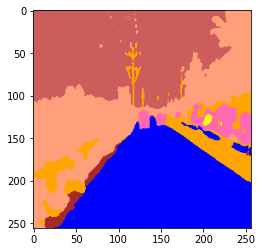

In [0]:

from matplotlib import image
from matplotlib import pyplot

pyplot.imshow(color_image)
pyplot.show()

uint8
(1080, 1920, 3)


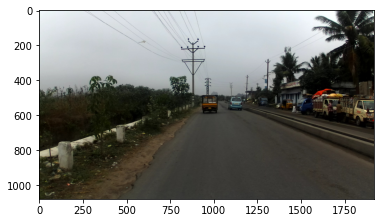

In [0]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread(x_path[1])
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

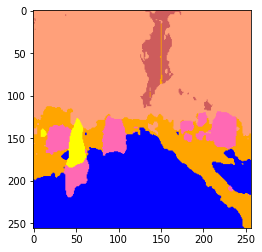

In [0]:
image_te = []
image = cv2.imread(x_path[300])
img = cv2.resize(image, (256, 256))
img = np.float32(img)  / 255 
image_te.append(img)
image_te = np.array(image_te)
result = model.predict(image_te)
result = np.argmax(result, axis=3)
colors = np.array([
    [255, 192 ,203	],      
    [255, 160, 122],     
    [255, 105, 180],      
    [205,  92,  92],        
    [255, 165,   0],    
    [255, 255,   0],      
    [165,  42,  42],     
    [0,   0, 255]           
], dtype=np.int)
image_y_te = []

color_image = np.zeros(
        (result.shape[1], result.shape[2], 3), dtype=np.int)
for i in range(8):
  color_image[result[0] == i] = colors[i]
image_y_te.append(color_image)
image_y_te = np.array(image_y_te)

from matplotlib import image
from matplotlib import pyplot

pyplot.imshow(color_image)
pyplot.show()

uint8
(1080, 1920, 3)


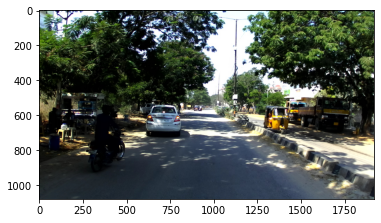

In [0]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread(x_path[300])
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

In [0]:
%cd /content/drive/My Drive/IDD/Output
!pwd

/content/drive/My Drive/IDD/Output
/content/drive/My Drive/IDD/Output


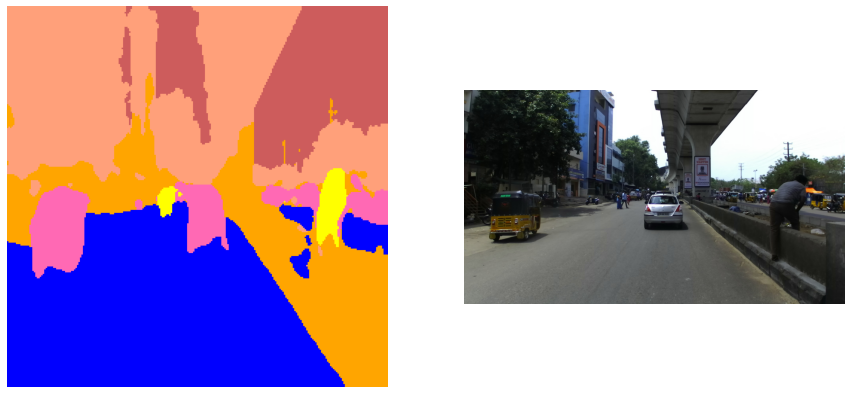


100%|██████████| 2009/2009 [31:49<00:00,  1.05it/s]

Write to:0002421_leftImg8bit.jpg


In [0]:
from PIL import Image
from IPython.display import clear_output
for test_img in tqdm(range(len(x_path))):
    clear_output(wait=True)
    image = cv2.imread(x_path[test_img])
    img = cv2.resize(image, (256, 256))
    img = np.float32(img)  / 255 

    image = np.array(img)
    result = model.predict(np.expand_dims(image,axis = 0))
    result = np.argmax(result, axis=3)
    colors = np.array([
    [255, 192 ,203],      
    [255, 160, 122],     
    [255, 105, 180],      
    [205,  92,  92],        
    [255, 165,   0],    
    [255, 255,   0],      
    [165,  42,  42],     
    [0,   0, 255]           
  ], dtype=np.int)
    color_image = np.zeros(
          (result.shape[1], result.shape[2], 3), dtype=np.int)
    for i in range(8):
        color_image[result[0] == i] = colors[i]
    from matplotlib import image
    from matplotlib import pyplot
    #pyplot.figure(figsize=(30, 30))
    fig, (ax0, ax1) = pyplot.subplots(ncols=2,figsize=(15,15))
    
    #ax0.figure(figsize=(10, 10))
    ax0.axis('off')
    ax0.imshow(color_image)
    import matplotlib.image as mpimg
    #ax1.figure(figsize=(10, 10))
    ax1.axis('off')
    ax1.imshow(mpimg.imread(x_path[test_img]))
    pyplot.savefig(x_path[test_img].split('/')[-1])
    pyplot.show()
    print("Write to:"+x_path[test_img].split('/')[-1])
